In [1]:
import numpy as np
import pandas as pd

In [2]:
df = pd.read_csv("Q4.csv", index_col=0)
x, y = np.split(df, [1], axis=1)
df.head(5)

,x,y
1,1.510086,6.521088
2,1.074133,4.108957
3,-0.884147,-1.776799
4,0.116655,1.813323
5,1.851628,7.329740


In [3]:
def mask_k(x, k, top=True, inplace=False):
    if not top:
        x = -x
    m, n = x.shape
    # get (unsorted) indices of top-k values
    topk_indices = np.argpartition(x, -k, axis=1)[:, -k:]
    # get k-th value
    rows, _ = np.indices((m, k))
    kth_vals = x[rows, topk_indices].min(axis=1)
    # get boolean mask of values smaller than k-th
    best = x >= kth_vals[:, None]
    return best

In [4]:
def kernel(u, bandwidth=1): 
    return np.exp(-0.5 * (u / bandwidth)**2) / (np.sqrt(2 * np.pi) * bandwidth)

In [5]:
def univariate_kernelh_knn(covariates, y, bandwidth=1, neighbors=5):
    if isinstance(covariates, pd.DataFrame):
        covariates = covariates.values

    if isinstance(y, pd.DataFrame):
        y = y.values

    def inner(datapoints):
        distance = np.linalg.norm(datapoints[:, None, :]-covariates, axis=2)

        closest_points = mask_k(distance, neighbors, top=False)
        best_k_distances = np.where(~closest_points, np.inf, distance)
        weights = kernel(best_k_distances, bandwidth)

        m = weights @ y.squeeze()
        m /= weights.sum(axis=1)
        return m
    return inner

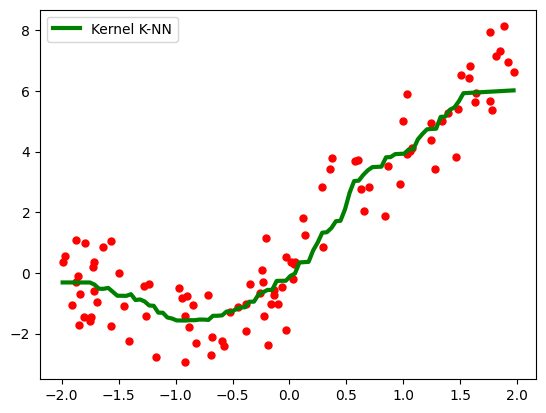

In [6]:
import matplotlib.pyplot as plt
plt.plot(x, y, 'ro', ms=5)

datapoints = np.linspace(x.min(), x.max(), 100)
plt.plot(datapoints, univariate_kernelh_knn(x, y, bandwidth=1, neighbors=20)(datapoints), 'g-', lw=3, label='Kernel K-NN')
plt.legend(loc='best')
plt.show()

In [7]:
def scorer(y_true, y_pred, order=2):
    return np.mean(np.abs(y_true - y_pred) ** order)


def loocv_score(x, y, bandwidth, neighbors):
    n = len(x)
    
    if isinstance(x, pd.DataFrame):
        x = x.values

    if isinstance(y, pd.DataFrame):
        y = y.values
    
    scores = []
    for i in range(n):
        x_train = np.delete(x, i, axis=0)
        y_train = np.delete(y, i)
        y_true = np.array(y[i, np.newaxis])
        y_pred = univariate_kernelh_knn(x_train, y_train, bandwidth, neighbors)(np.array(x[i, np.newaxis]))
        scores.append(scorer(y_true, y_pred))
    return np.mean(scores)


def optim(x, y, bandwidths, neighbors):
    hyperparameter_scores = []
    for bandwidth in bandwidths:
        for neighbor in neighbors:
            score = loocv_score(x, y, bandwidth, neighbor)
            hyperparameter_scores.append([bandwidth, neighbor, score])
    return hyperparameter_scores

In [8]:
scores = optim(x, y, bandwidths=np.arange(0.01, 2.01, 0.01), neighbors=np.arange(1, 51))

In [9]:
ans = pd.DataFrame(scores, columns=['bandwidth', 'neighbors', 'score'])
max_index = ans['score'].idxmin()
best_model = ans.loc[max_index, :]
best_model

bandwidth    0.650000
neighbors    9.000000
score        0.907669
Name: 3208, dtype: float64

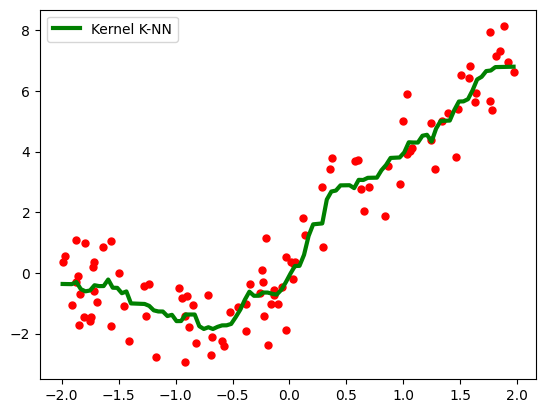

In [10]:
plt.plot(x, y, 'ro', ms=5)

datapoints = np.linspace(x.min(), x.max(), 100)
plt.plot(datapoints, univariate_kernelh_knn(x, y, bandwidth=best_model['bandwidth'], neighbors=int(best_model['neighbors']))(datapoints), 'g-', lw=3, label='Kernel K-NN')
plt.legend(loc='best')
plt.show()